# Q2**.1**

🔍 Found 17 image(s) for calibration.

 Checkerboard not detected in 1 (7).jpg
 Checkerboard not detected in 1 (3).jpg
 Checkerboard not detected in 1 (4).jpg


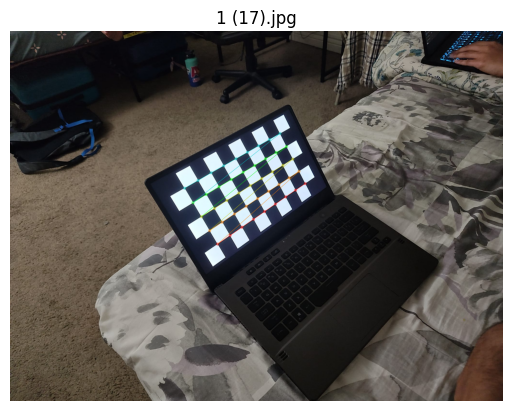

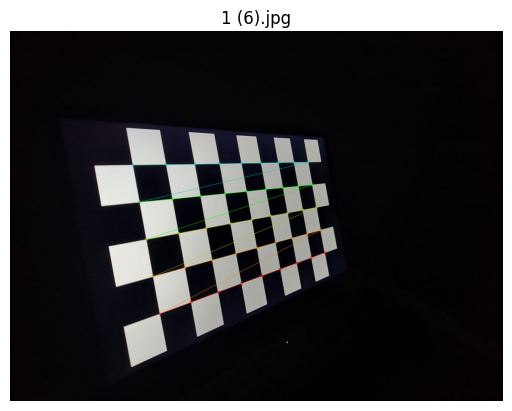

 Checkerboard not detected in 1 (2).jpg


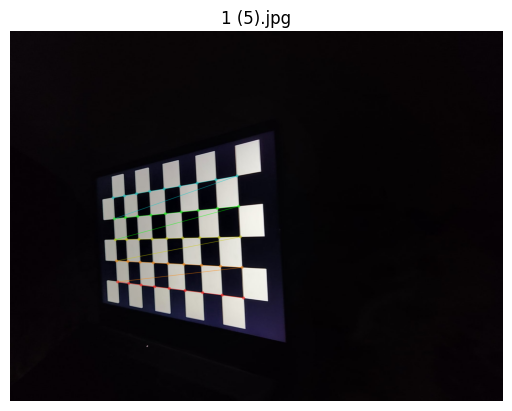

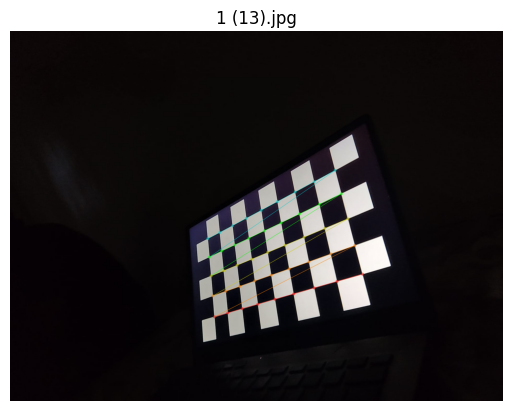

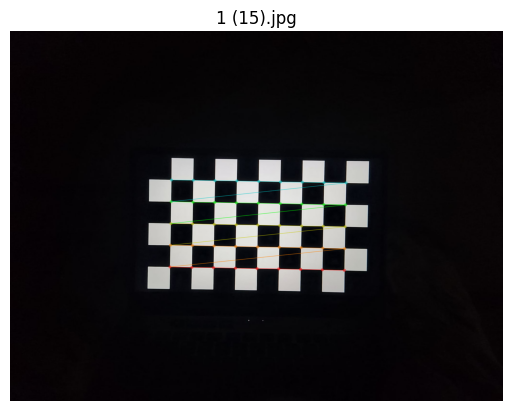

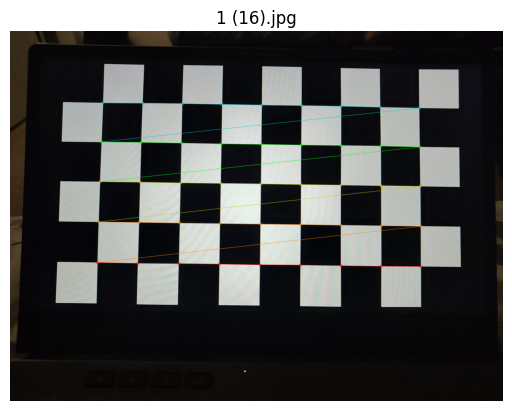

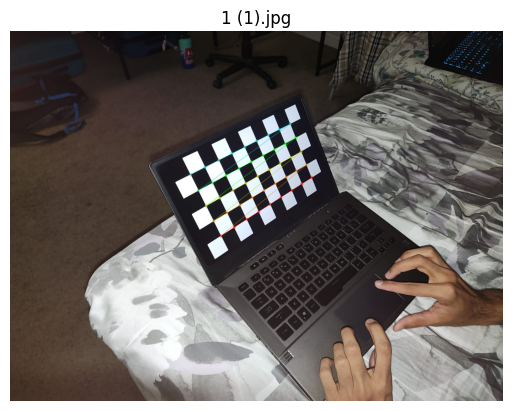

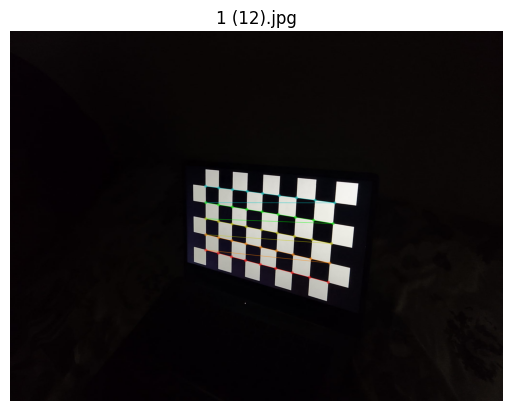

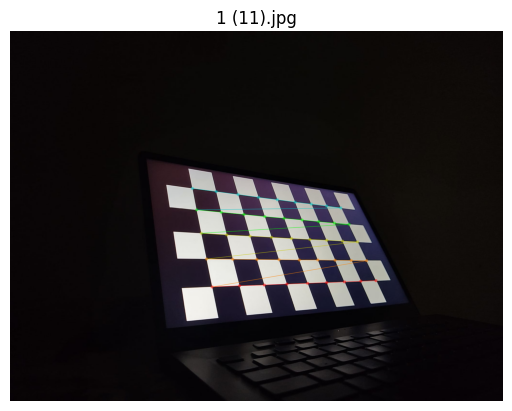

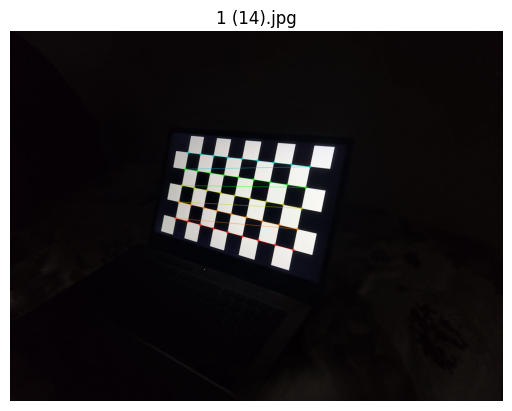

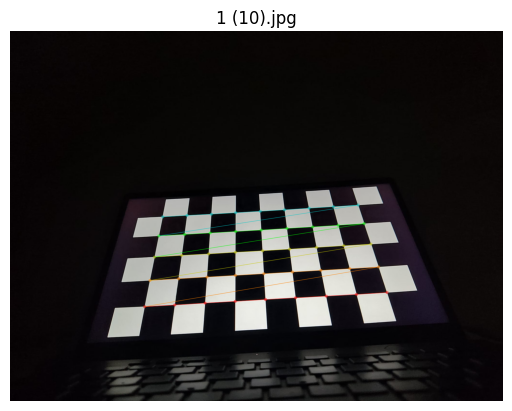

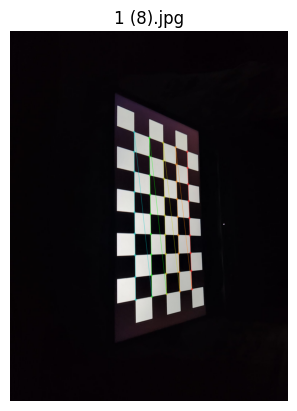

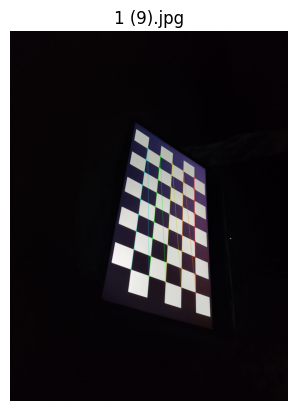


 Camera Intrinsic Matrix (K):
[[ 1476.86        0.00     1047.98]
 [    0.00     1472.36      728.28]
 [    0.00        0.00        1.00]]

 Camera Parameters:
fx (focal length x):     1476.86
fy (focal length y):     1472.36
cx (principal point x):  1047.98
cy (principal point y):  728.28

 Mean Reprojection Error:
0.247561


In [ ]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Set your image folder path
image_folder = '/content'

# Checkerboard dimensions (number of inner corners per row and column)
CHECKERBOARD = (9, 5)

# 3D world coordinates (z = 0 for a flat checkerboard)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Arrays to store points from all images
objpoints = []
imgpoints = []
valid_images = []

# Load all checkerboard images
image_files = glob.glob(os.path.join(image_folder, '*.jpg'))
print(f"🔍 Found {len(image_files)} image(s) for calibration.\n")

# Detect checkerboard corners
for fname in image_files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCornersSB(gray, CHECKERBOARD, None)

    if not ret:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
        flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK
        ret, corners = cv2.findChessboardCorners(blurred, CHECKERBOARD, flags)

        if ret:
            corners = cv2.cornerSubPix(
                blurred, corners, (11, 11), (-1, -1),
                criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            )

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        valid_images.append(fname)

        img_drawn = cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        plt.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(fname))
        plt.axis('off')
        plt.show()
    else:
        print(f" Checkerboard not detected in {os.path.basename(fname)}")

# Initial calibration
if objpoints and imgpoints:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Remove images with high reprojection error
    MAX_ACCEPTABLE_ERROR = 2.0
    refined_objpoints = []
    refined_imgpoints = []
    refined_images = []

    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        if error < MAX_ACCEPTABLE_ERROR:
            refined_objpoints.append(objpoints[i])
            refined_imgpoints.append(imgpoints[i])
            refined_images.append(valid_images[i])

    # Final calibration with refined images
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(refined_objpoints, refined_imgpoints, gray.shape[::-1], None, None)

    fx = mtx[0, 0]
    fy = mtx[1, 1]
    cx = mtx[0, 2]
    cy = mtx[1, 2]

    print("\n Camera Intrinsic Matrix (K):")
    print(f"[[{fx:8.2f}    {mtx[0,1]:8.2f}    {cx:8.2f}]")
    print(f" [{mtx[1,0]:8.2f}    {fy:8.2f}    {cy:8.2f}]")
    print(f" [{mtx[2,0]:8.2f}    {mtx[2,1]:8.2f}    {mtx[2,2]:8.2f}]]")

    print("\n Camera Parameters:")
    print(f"fx (focal length x):     {fx:.2f}")
    print(f"fy (focal length y):     {fy:.2f}")
    print(f"cx (principal point x):  {cx:.2f}")
    print(f"cy (principal point y):  {cy:.2f}")

    # Final reprojection error
    total_error = 0
    for i in range(len(refined_objpoints)):
        imgpoints2, _ = cv2.projectPoints(refined_objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(refined_imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        total_error += error

    print("\n Mean Reprojection Error:")
    print(f"{total_error / len(refined_objpoints):.6f}")
else:
    print("\n No valid checkerboard detections found. Calibration aborted.")


# Q2**.2**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
img1 = cv2.imread('/content/content/1111.jpg')
img2 = cv2.imread('/content/content/2222.jpg')

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


In [ ]:
orb = cv2.ORB_create(5000)

kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)


In [ ]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
F = F / F[2, 2]
print("Fundamental Matrix:\n", F)


Fundamental Matrix:
 [[ 1.95100906e-08  5.70929074e-06 -3.63997109e-03]
 [-4.96269983e-06 -7.53444456e-07 -4.88435345e-04]
 [ 3.42882709e-03 -5.17521829e-04  1.00000000e+00]]


In [ ]:
# Compute epipole in image 1 (right null space of F)
U, S, Vt = np.linalg.svd(F)
e1 = Vt[-1]
e1 = e1 / e1[2]
print("Epipole in Image 1:", e1)

# Compute epipole in image 2 (left null space of F)
U, S, Vt = np.linalg.svd(F.T)
e2 = Vt[-1]
e2 = e2 / e2[2]
print("Epipole in Image 2:", e2)


Epipole in Image 1: [-195.31675535  638.21968477    1.        ]
Epipole in Image 2: [181.9193224  691.63488999   1.        ]


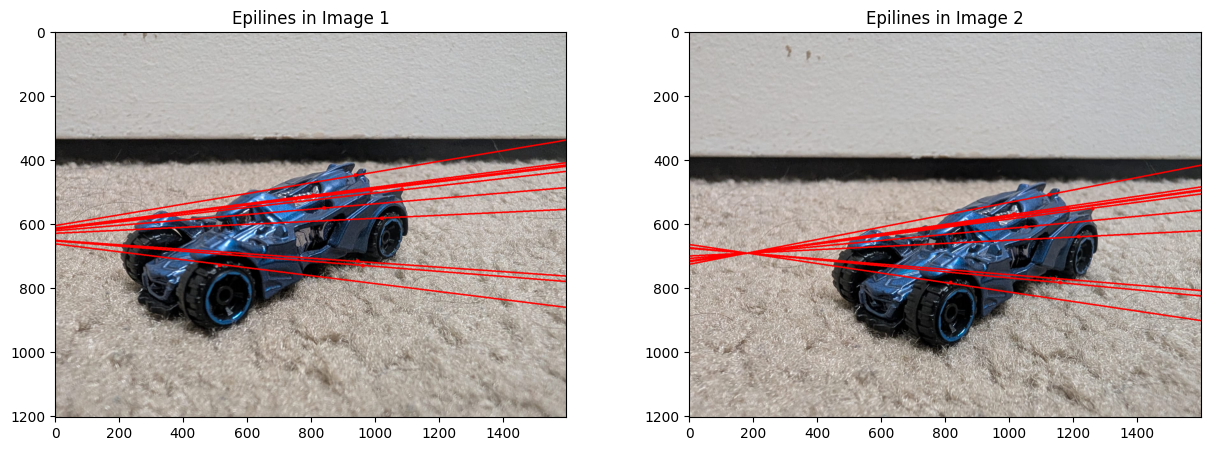

In [ ]:
def drawlines(img1, img2, lines, pts1, pts2, epipole1=None, epipole2=None):
    '''
    img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines
    epipole1, epipole2 - 3D epipole coordinates in homogeneous form (optional)
    '''
    r, c = img1.shape[:2]
    img1_color = img1.copy()
    img2_color = img2.copy()

    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        # Dark blue color in BGR
        color = (0, 0, 300)
        x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2]+r_line[0]*c)/r_line[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 3)  # line thickness = 3
        img1_color = cv2.circle(img1_color, tuple(np.int32(pt1)), 6, color, -1)
        img2_color = cv2.circle(img2_color, tuple(np.int32(pt2)), 6, color, -1)

    # Draw epipoles with larger circles
    if epipole1 is not None:
        img1_color = cv2.circle(img1_color, (int(epipole1[0]), int(epipole1[1])), 15, (0, 0, 255), -1)
    if epipole2 is not None:
        img2_color = cv2.circle(img2_color, (int(epipole2[0]), int(epipole2[1])), 15, (0, 0, 255), -1)

    return img1_color, img2_color



# Only keep inlier points
pts1_in = pts1[mask.ravel() == 1]
pts2_in = pts2[mask.ravel() == 1]

# Pick 10 random matches for visualization
np.random.seed(42)
idx = np.random.choice(len(pts1_in), 10, replace=False)
pts1_sample = pts1_in[idx]
pts2_sample = pts2_in[idx]

# Compute epilines
lines1 = cv2.computeCorrespondEpilines(pts2_sample.reshape(-1,1,2), 2, F).reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1_sample.reshape(-1,1,2), 1, F).reshape(-1,3)

img1_lines, img2_points = drawlines(img1, img2, lines1, pts1_sample, pts2_sample)
img2_lines, img1_points = drawlines(img2, img1, lines2, pts2_sample, pts1_sample)

# Show result
plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
plt.title('Epilines in Image 1')
plt.subplot(122), plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
plt.title('Epilines in Image 2')
plt.show()


In [ ]:
# You should ideally calibrate the camera and use real K
K = np.eye(3)
E = K.T @ F @ K
print("Essential Matrix:\n", E)


Essential Matrix:
 [[-2.45952325e-11 -5.30533825e-06  8.80013961e-03]
 [ 5.81003481e-06  3.12417947e-07 -5.80445549e-03]
 [-9.55981219e-03  4.64087929e-03  1.00000000e+00]]


In [ ]:
def drawlines(img1, img2, lines, pts1, pts2, epipole1=None, epipole2=None):
    '''
    img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines
    epipole1, epipole2 - 3D epipole coordinates in homogeneous form (optional)
    '''
    r, c = img1.shape[:2]
    img1_color = img1.copy()
    img2_color = img2.copy()

    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        # Generate a random color for each line (in BGR)
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r_line[2] / r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2] + r_line[0] * c) / r_line[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 2)
        img1_color = cv2.circle(img1_color, tuple(np.int32(pt1)), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(np.int32(pt2)), 5, color, -1)

    # Draw epipoles with a distinct color (red)
    if epipole1 is not None:
        img1_color = cv2.circle(img1_color, (int(epipole1[0]), int(epipole1[1])), 15, (0, 0, 255), -1)
    if epipole2 is not None:
        img2_color = cv2.circle(img2_color, (int(epipole2[0]), int(epipole2[1])), 15, (0, 0, 255), -1)

    return img1_color, img2_color
